In [62]:
import numpy as np
import pandas as pd
from janitor import clean_names
from datetime import timedelta
import ee
import pyproj
import requests

# Modules not needed
import geopandas as gpd
import polars as pl
import matplotlib.pyplot as plt
# import zipfile
# import os
# import request
import rasterio
# import geeS2downloader
from IPython.display import Image

In [2]:
# Read leak df to get dates
leaks_raw = pd.read_excel("../data/raw/Ordenes Fugas Ejecutadas Dic2022 XY.xlsx")
leaks_raw.head()

,Id,FECHA DE CREACIÓN,FECHA DE INICIO,FECHA FINAL,CODUNIDAD,FECHALEGALIZACION,NOMBREESTADO,NOMBRETRABAJO,CAUSAL,X,Y
0,1,2021-10-14,2022-11-24,2022-12-07,757,2022-12-07,Cerrada,FTA - FUGA EN TOMA DE AGUA,SE CANCELA,781021.888082,2.428227e+06
1,2,2021-09-28,2022-11-24,2022-12-07,757,2022-12-07,Cerrada,FTA - FUGA EN TOMA DE AGUA,SE CANCELA,778394.890320,2.426703e+06
2,3,2022-03-30,2022-11-24,2022-11-26,757,2022-12-22,Cerrada,FTA - FUGA EN TOMA DE AGUA,SE CANCELA,786182.935000,2.421650e+06
3,4,2022-04-24,2022-11-25,2022-11-26,757,2022-12-22,Cerrada,FTA - FUGA EN TOMA DE AGUA,SE CANCELA,780261.739782,2.421571e+06
4,5,2022-06-07,2022-11-25,2022-11-26,757,2022-12-22,Cerrada,FTA - FUGA EN TOMA DE AGUA,SE CANCELA,781486.184276,2.430545e+06


In [3]:
# Clean leaks data
leaks_clean = clean_names(leaks_raw)
leaks_clean.columns # The column of interest is fecha_de_inicio


Index(['id', 'fecha_de_creacion', 'fecha_de_inicio', 'fecha_final',
       'codunidad', 'fechalegalizacion', 'nombreestado', 'nombretrabajo',
       'causal', 'x', 'y'],
      dtype='object')

In [4]:
# First we need to filter leaks that are detected in the main pipe. Code in column nombretrabajo: FTC

# Column with codes
leaks_clean["leak_type"] = leaks_clean.nombretrabajo.str.extract(r"([A-Z]+)", expand = False)

# Filter
leaks_clean = leaks_clean.query("leak_type == 'FTC'")

# Second, we need to filter to causal == "SE REPARA FTC, GENERA BA"
leaks_clean = leaks_clean.query("causal == 'SE REPARA FTC, GENERA BA'")

# Drop irrelevant columns
leaks_clean = leaks_clean.drop(["codunidad", "nombreestado", "nombretrabajo", "fecha_de_creacion"], axis = 1)

# Sort df by fecha_de_inicio
leaks_clean = leaks_clean.sort_values(by = "fecha_de_inicio").reset_index(drop = True)

# Show clean df 
leaks_clean.head() # This df is going to be necessary to define the date of each image to be downloaded

,id,fecha_de_inicio,fecha_final,fechalegalizacion,causal,x,y,leak_type
0,2366,2022-12-01,2022-12-01,2022-12-01,"SE REPARA FTC, GENERA BA",781563.335110,2.419492e+06,FTC
1,2479,2022-12-01,2022-12-01,2022-12-01,"SE REPARA FTC, GENERA BA",785033.684233,2.423310e+06,FTC
2,2443,2022-12-01,2022-12-01,2022-12-01,"SE REPARA FTC, GENERA BA",781521.553633,2.419196e+06,FTC
3,2460,2022-12-02,2022-12-02,2022-12-02,"SE REPARA FTC, GENERA BA",779658.087686,2.416386e+06,FTC
4,2409,2022-12-02,2022-12-02,2022-12-02,"SE REPARA FTC, GENERA BA",781491.668852,2.419196e+06,FTC


In [5]:
# Initialize GEE API
ee.Initialize()

In [6]:
# Parameters for collection

# Point of interest (Center of Aguascalientes City) EPGS: 
lat = 21.8833333
lon = -102.3
poi = ee.Geometry.Point(lon, lat)  

# Area of interest
aoi = ee.Geometry.LinearRing([ 
    [-102.3695755, 21.9745687],
    [-102.211993, 21.9745687],
    [-102.211993, 21.8085958],
    [-102.3695755, 21.8085958],
    [-102.3695755, 21.9745687]
    ])

# Dates
end_date = leaks_clean.fechalegalizacion[0] - timedelta(days = 1)
start_date = end_date - timedelta(days = 7)

print("inicio:", start_date, "\nfinal:", end_date)

inicio: 2022-11-23 00:00:00 
final: 2022-11-30 00:00:00


In [17]:
# Image collection
ags_collection = ee.ImageCollection("COPERNICUS/S2_SR_HARMONIZED")\
                          .filterBounds(aoi)\
                          .filterDate(ee.Date(start_date), ee.Date(end_date))\
                          .sort("CLOUD_COVERAGE_ASSESMENT")

print("Total images:", ags_collection.size().getInfo())

# Add latitude and longitude to the collection
# ags_collection = ags_collection.addBands(ee.Image.pixelLonLat())
ags_list = ags_collection.toList(ags_collection.size())

img = ags_collection.first()

print("Date of selected image:", ee.Date(img.get("system:time_start")).format("yyyy-MM-dd").getInfo())

Total images: 3
Date of selected image: 2022-11-23


In [33]:
def get_image(start, end, poi_leak):
    collection = ee.ImageCollection("COPERNICUS/S2_SR_HARMONIZED")\
    .filterBounds(poi_leak)\
    .filterDate(ee.Date(start), ee.Date(end))\
    .sort("CLOUD_COVERAGE_ASSESMENT")

    print("Images found: ", collection.size().getInfo())

    img = collection.first()

    print("Date of selected image: ", ee.Date(img.get("system:time_start")).format("yyyy-MM-dd").getInfo()) 
    
    return img  

In [34]:
get_image(start = start_date,  end = end_date, poi_leak = poi) # It works

Images found:  3
Date of selected image:  2022-11-23


In [46]:
def bands_clip_image(image, buffer_size = 100, bands = ["B4", "B3", "B2"]):
    # Clip image
    image = image.clip(poi.buffer(buffer_size).bounds(proj = "EPSG:32613", maxError = 0.001))

    # Select bands
    image = image.select(bands)

    return image

In [47]:
img = get_image(start = start_date,  end = end_date, poi_leak = poi)
img = bands_clip_image(img, bands = bands)

Images found:  3
Date of selected image:  2022-11-23


In [50]:
def download_image(image, path, date_label):
    url = image.getDownloadURL(
        {
        "scale": 10,
        "crs": "EPSG:32613",
        "fileFormat": "GeoTIFF",
        "maxPixels": 1e13
        }
    )

    r = requests.get(url, allow_redirects = True)
    open(path + "S2" + "_" + str(date_label)[:10] + ".zip", "wb").write(r.content)
    print("Download complete")

In [51]:
download_image(img, "../data/patches/", date_label = leaks_clean.fechalegalizacion[0])

Download complete


## Automate Download for all the leaks

In [59]:
# Add geometry column
leaks_clean["geometry"] = gpd.points_from_xy(leaks_clean["x"], leaks_clean["y"])

# Transform df to geodf
leaks_gdf = gpd.GeoDataFrame(leaks_clean, geometry = "geometry", crs = "EPSG:32613")

In [71]:
bands = ["B4", "B3", "B2", "B1", "B5", "B6", "B7", "B8", "B8A", "B9", "B11", "B12", "WVP"]

for leak in range(leaks_clean.shape[0]):
    print("="*100)
    print("Leak index: ", leak)
    
    if leak == 0:
        previous_end_date = ""

    if previous_end_date == end_date:
        print("Leak detected at the same date")
        next
    
    # Date for zip label
    date_lab = leaks_clean.fechalegalizacion[leak]
    
    # Dates for patch
    end_date = leaks_clean.fecha_final[leak] - timedelta(days = 1)
    start_date = end_date - timedelta(days = 7)

    # Coords of leaks
    leak_lat_ogcrs = leaks_clean["y"][leak]
    leak_lon_ogcrs = leaks_clean["x"][leak]

    # Transform to degrees
    transformer = pyproj.Transformer.from_crs("epsg:32613", "epsg:4326")
    leak_lon, leak_lat = transformer.transform(leak_lon_ogcrs, leak_lat_ogcrs)

    # Point of leak
    poi = ee.Geometry.Point([leak_lat, leak_lon])

    if previous_end_date != end_date:
        print("Leak coords: ", (leak_lat, leak_lon), "\n", 
              "Start and end dates: ", (start_date, end_date))
    
        img = get_image(start = start_date, end = end_date, poi_leak = poi)
        img = bands_clip_image(img, buffer_size = 100, bands = bands)
        download_image(image = img, path = "../data/patches/", date_label = date_lab)

    previous_end_date = end_date

Lea index 0
Leak coords:  (-102.27569493914878, 21.857000495984423) 
 Start and end dates:  (Timestamp('2022-11-23 00:00:00'), Timestamp('2022-11-30 00:00:00'))
Images found:  3
Date of selected image:  2022-11-23
Download complete
Lea index 1
Leak detected at the same date
Lea index 2
Leak detected at the same date
Lea index 3
Leak detected at the same date
Leak coords:  (-102.294641764373, 21.829265790225637) 
 Start and end dates:  (Timestamp('2022-11-24 00:00:00'), Timestamp('2022-12-01 00:00:00'))
Images found:  3
Date of selected image:  2022-11-25
Download complete
Lea index 4
Leak detected at the same date
Lea index 5
Leak detected at the same date
Lea index 6
Leak detected at the same date
Leak coords:  (-102.33410278027021, 21.876843362364117) 
 Start and end dates:  (Timestamp('2022-11-27 00:00:00'), Timestamp('2022-12-04 00:00:00'))
Images found:  3
Date of selected image:  2022-11-28
Download complete
Lea index 7
Leak detected at the same date
Leak coords:  (-102.243420481

In [112]:
buff_size = 10000

display(Image(url = img.clip(poi.buffer(buff_size).bounds(proj = "EPSG:32613", maxError = 0.001)).getThumbURL({"min": 0,
                                                "max": 3000,
                                                "dimensions": 800,
                                                "bands": ["B4", "B3", "B2"]})))


In [36]:
bands = ["B4", "B3", "B2", "B1", "B5", "B6", "B7", "B8", "B8A", "B9", "B11", "B12", "WVP"]

In [27]:
# Define bands for download
# bands = ["B4", "B3", "B2", "B1", "B8", "B9"]

# Clip image
img = img.clip(poi.buffer(100).bounds(proj = "EPSG:32613", maxError = 0.001))

# Select bands
img = img.select(bands)

In [30]:
# Download GeoTIFF
url = img.getDownloadURL(
    {
    "scale": 10,
    "crs": "EPSG:32613",
    "fileFormat": "GeoTIFF",
    "maxPixels": 1e13
    }
)

r = requests.get(url, allow_redirects = True)
open("../data/images/" + "S2" + "_" + str(leaks_clean.fechalegalizacion[0])[:10], "wb").write(r.content)


16088

In [104]:
"S2" + "_" + str(leaks_clean.fechalegalizacion[0])[:10]

'S2_2022-12-01'

In [9]:
# Save first image and clip with a rectangle buffer
img0 = ee.Image(ags_list.get(0)) # Raw image
# img0 = img0.addBands(ee.Image.pixelLonLat())
img0 = img0.select(bands) # Select bands
img0 = img0.clip(poi.buffer(buff_size).bounds(proj = "EPSG:32613", maxError = 0.1)) # Rectangle buffer

In [10]:
# Download link
link = img0.getDownloadURL(
    {
    "scale": 10,
    "crs": "EPSG:32613",
    "fileFormat": "GeoTIFF",
    "maxPixels": 1e13
    }
)

print(link)

https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/daa755daa025b1390b7639337dc90e5d-7d49d455cec7de3e1e016bcf69b57a92:getPixels


## Download GeoTIFFs

In [13]:
# Bands to download
bands = ["B4", "B3", "B2", "B1", "B5", "B6", "B7", "B8", "B8A", "B9", "B11", "B12", "WVP"]

In [10]:
import geemap
import ee
from geeS2downloader import GEES2Downloader

# If it is not yet authenticated, uncomment the line below
# ee.Authenticate()

# img = ags_collection

Map = geemap.Map(center=(23, -102.4), zoom=9)
Map.addLayer(img, {'min': 0, 'max': 3000, 'bands': ['B4', 'B3', "B2"], "region": poi.buffer(10000)}, 'Cloud Probability', True, 1)
Map

c:\Users\Erick\AppData\Local\Programs\Python\Python311\Lib\site-packages\traittypes\traittypes.py:20: DeprecationWarning: 
            Sentinel is not a public part of the traitlets API.
            It was published by mistake, and may be removed in the future.
            
  Empty = Sentinel('Empty', 'traittypes',


Map(center=[23, -102.4], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=HBox(children=…

In [15]:
# Export with geemap
geemap.ee_export_image(img, "../data/images/s2_prueba.tif", scale=10)

Generating URL ...
An error occurred while downloading.
Image.select: Pattern 'B5' did not match any bands.


In [24]:
# Export with GEE2Downloader
downloader = GEES2Downloader()

downloader.download(img = img, band = "B4")



Retrieving band info
Dividing band in 1 tiles


Tiles:   0%|          | 0/1 [00:00<?, ?tile/s]

Tile[0:1990,0:1995]:   0%|          | 0.00/5.16M [00:00<?, ?b/s]

Finished. The result can be accessed at obj.array


(1990, 1995)


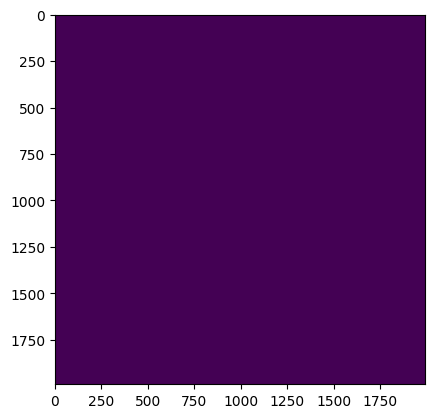

In [25]:
print(downloader.array.shape)

plt.imshow(downloader.array.)

In [26]:
downloader.band_info

{'data_type': {'type': 'PixelType',
  'precision': 'int',
  'min': 0,
  'max': 65535},
 'dimensions': [1990, 1995],
 'origin': [6910, 6768],
 'crs': 'EPSG:32613',
 'crs_transform': [10, 0, 699960, 0, -10, 2500020],
 'nominal_scale': 10}